In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from tensorflow.keras import backend as K

## Load the data

In [44]:
df_train = pd.read_csv("../01.Data/german_credit_train.csv")
df_test = pd.read_csv("../01.Data/german_credit_test.csv")

## EDA

In [45]:
df_train.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [46]:
print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (3999, 21)
Test dataset shape: (1001, 21)


In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CheckingStatus            3999 non-null   object
 1   LoanDuration              3999 non-null   int64 
 2   CreditHistory             3999 non-null   object
 3   LoanPurpose               3999 non-null   object
 4   LoanAmount                3999 non-null   int64 
 5   ExistingSavings           3999 non-null   object
 6   EmploymentDuration        3999 non-null   object
 7   InstallmentPercent        3999 non-null   int64 
 8   Sex                       3999 non-null   object
 9   OthersOnLoan              3999 non-null   object
 10  CurrentResidenceDuration  3999 non-null   int64 
 11  OwnsProperty              3999 non-null   object
 12  Age                       3999 non-null   int64 
 13  InstallmentPlans          3999 non-null   object
 14  Housing                 

### Missing Values

Let's study if there is any missing values in the datasets.

In [48]:
print(f'Missing values in the whole train dataset: {df_train.isnull().sum().sum()}')
print(f'Missing values in the whole test dataset: {df_test.isnull().sum().sum()}')

# Check if there is any missing values in the datasets




Missing values in the whole train dataset: 0
Missing values in the whole test dataset: 0


Let's split the data between numerical and categorical features.

In [49]:
numeric_features = df_train.select_dtypes(include=[np.number])
print(f"Numerical features: {numeric_features.columns.tolist()}")

categorical_features = df_train.select_dtypes(include=[object]).drop(columns=['Risk'])
print(f"Categorical features: {categorical_features.columns.tolist()}")

target = df_train['Risk']

Numerical features: ['LoanDuration', 'LoanAmount', 'InstallmentPercent', 'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount', 'Dependents']
Categorical features: ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']


## Analysis of numerical features

Let's study the distribution of the numerical features

In [50]:
numeric_features.describe()

,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents
count,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000
mean,21.252063,3482.700925,2.968242,2.838460,35.896224,1.470618,1.163541
std,11.125595,2498.295579,1.131982,1.115138,10.628733,0.568098,0.369905
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1300.500000,2.000000,2.000000,28.000000,1.000000,1.000000
50%,21.000000,3250.000000,3.000000,3.000000,36.000000,1.000000,1.000000
75%,29.000000,5363.000000,4.000000,4.000000,44.000000,2.000000,1.000000
max,64.000000,11676.000000,6.000000,6.000000,74.000000,3.000000,2.000000


Let's plot the distribution of the numerical features

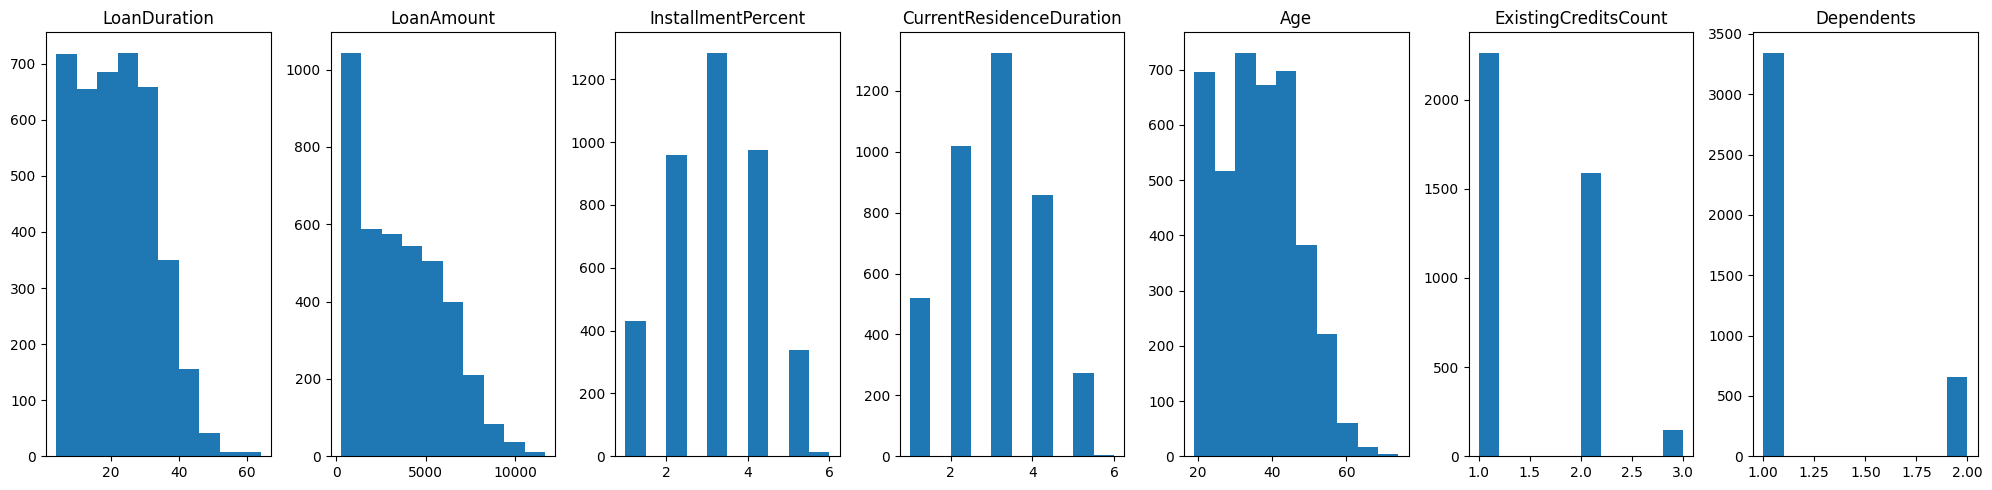

In [51]:
# Determine the number of columns in the DataFrame
num_columns = len(numeric_features.columns)

# Create a figure with 2 row of subplots
fig, axes = plt.subplots(1, num_columns, figsize=(20, 5))  # Adjust figsize as needed

# Flatten the axes array for easy iteration (though it's already 1D in this case)
axes = axes.flatten()

# Plot each column in the DataFrame
for i, col in enumerate(numeric_features.columns):
    axes[i].hist(numeric_features[col])
    axes[i].set_title(col)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

- The 'InstallmentPercent' and 'CurrentResidenceDuration' columns seems to have a Gaussian distribution.
- 'LoanDuration', 'LoanAmount', and 'Age' columns have a right-skewed distribution.

In [52]:
for column in numeric_features.columns:
    print(f'The feature {column} contains {len(df_train[column].unique())} unique values')

The feature LoanDuration contains 57 unique values
The feature LoanAmount contains 2794 unique values
The feature InstallmentPercent contains 6 unique values
The feature CurrentResidenceDuration contains 6 unique values
The feature Age contains 52 unique values
The feature ExistingCreditsCount contains 3 unique values
The feature Dependents contains 2 unique values


The value 'Dependant' takes only 2 values. Maybe we can encode it with a binary feature. <span style="color:red;">TO BE DISCUSSED</span>

Let's plot the correlation matrix to see the relationships between the features.

<Axes: >

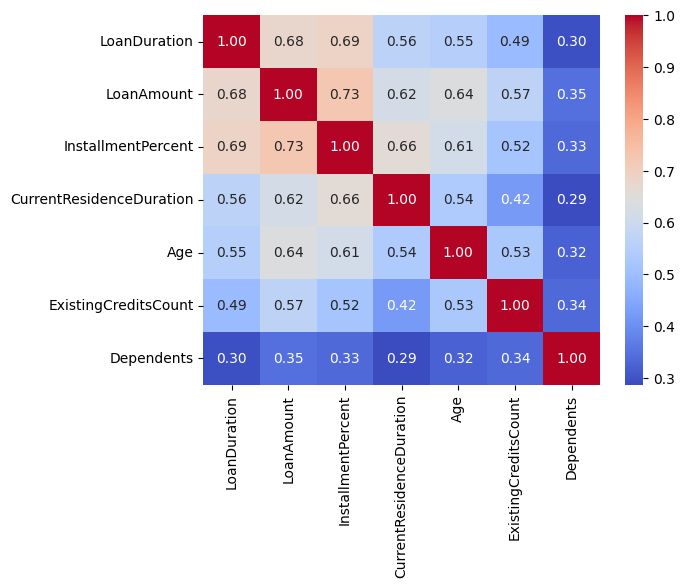

In [53]:
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

There is no big surprise in the correlation matrix. Some features are quite correlated with each other.

## Categorical features

In [54]:
for column in categorical_features.columns:
    print(f'The feature {column} contains {len(df_train[column].unique())} unique values')

The feature CheckingStatus contains 4 unique values
The feature CreditHistory contains 5 unique values
The feature LoanPurpose contains 11 unique values
The feature ExistingSavings contains 5 unique values
The feature EmploymentDuration contains 5 unique values
The feature Sex contains 2 unique values
The feature OthersOnLoan contains 3 unique values
The feature OwnsProperty contains 4 unique values
The feature InstallmentPlans contains 3 unique values
The feature Housing contains 3 unique values
The feature Job contains 4 unique values
The feature Telephone contains 2 unique values
The feature ForeignWorker contains 2 unique values


The values 'Sex', 'Telephone', 'ForeignWorker', 'Risk' takes only 2 values. Maybe we can encode it with a binary feature. <span style="color:red;">TO BE DISCUSSED</span>

In [55]:
target.value_counts(normalize=True)

Risk
No Risk    0.667417
Risk       0.332583
Name: proportion, dtype: float64

The split of the target variable is 1/3 vs. 2/3 which is a good split for a binary classification problem.

Let's analyze the categorical features in the dataset related to the target variable.

<Axes: xlabel='CheckingStatus'>

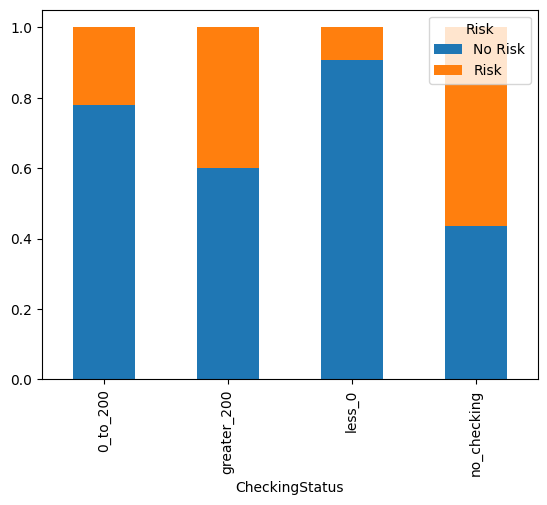

In [56]:
df_train.groupby('CheckingStatus')['Risk'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

- We note that the higher the checking account status, the higher the risk of the customer (no surprising). This categorical variable has to be encoded keeping the idea of ordinality. Maybe we can turn it into a numerical feature too. <span style="color:red;">TO BE DISCUSSED</span>
- The key point is that for the counts with no ckecking the Risk is almost 50%.

## Analysis of the evaluation metric

In [57]:
def compute_costs(LoanAmount):
    return({'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
            'Risk_Risk': 1.0, 'No Risk_Risk': 1.0})

Cette fonction calcule les coûts associés aux différentes combinaisons de prédictions et de vérités réelles. Les coûts sont définis comme suit :

- Risk_No Risk : Coût de prédire "No Risk" alors que la vérité est "Risk". Le coût est calculé comme 5.0 + 0.6 × LoanAmount.
- No Risk_No Risk : Coût de prédire "No Risk" alors que la vérité est "No Risk". Le coût est calculé comme 1.0 − 0.05 × LoanAmount.
- Risk_Risk : Coût de prédire "Risk" alors que la vérité est "Risk". Le coût est fixé à 1.0.
- No Risk_Risk : Coût de prédire "Risk" alors que la vérité est "No Risk". Le coût est fixé à 1.0.

In [58]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    A custom metric for the German credit dataset
    '''
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}
    custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
    costs = compute_costs(solution['LoanAmount'])
    y_true = solution['Risk']
    y_pred = submission['Risk']
    loss = (y_true=='Risk') * custom_weight['Risk'] *\
               ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
            (y_true=='No Risk') * custom_weight['No Risk'] *\
               ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])
    return loss.mean()

- Proportions réelles et d'entraînement :
    - real_prop : Proportions réelles des classes "Risk" et "No Risk" dans la population.
    - train_prop : Proportions des classes "Risk" et "No Risk" dans l'ensemble de données d'entraînement.

- Poids personnalisés :
    - custom_weight : Poids ajustés pour compenser la différence entre les proportions réelles et les proportions d'entraînement. Cela permet de donner plus de poids aux erreurs sur les classes sous-représentées.

- Calcul des coûts :
    - costs : Utilise la fonction compute_costs pour obtenir les coûts associés aux différentes combinaisons de prédictions et de vérités réelles.

- Vérités réelles et prédictions :
    - y_true : Vérités réelles (colonnes 'Risk' de solution).
    - y_pred : Prédictions (colonnes 'Risk' de submission).

- Calcul de la perte :
    - La perte est calculée en fonction des vérités réelles et des prédictions, en utilisant les coûts et les poids personnalisés.
    
- Moyenne de la perte :
    - La fonction retourne la moyenne de la perte calculée pour toutes les instances.

En résumé, cette métrique d'évaluation personnalisée prend en compte les coûts associés aux différentes combinaisons de prédictions et de vérités réelles, ainsi que les proportions réelles et d'entraînement des classes, pour calculer une perte moyenne pondérée.

## Creation of a first Pipeline

In [59]:
X_prepared = df_train.drop(columns=['Risk'])
y_prepared = df_train['Risk']

# Retire la colonne 'Risk' du dataframe des features catégorielles
categorical_features = categorical_features.columns
numerical_features = numeric_features.columns

#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.2, random_state=42)

In [60]:
#Création des transformateurs pour les colonnes catégorielles et numériques
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numerical_features),
('cat', OneHotEncoder(), categorical_features)
])

In [20]:
#Création du pipeline avec le préprocesseur et le classificateur
pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', RandomForestClassifier(random_state=42))
])

#Entraînement du modèle
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculer l'accuracy
accuracy = np.mean(y_test == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

## Préparation des données pour le calcul de la loss

# Réindexation des indexes
y_test = pd.DataFrame(y_test, columns=['Risk'])
y_pred = pd.DataFrame(y_pred, columns=['Risk'])
y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Affecter la colonne 'Risk' obtenue à X_test
y_test['LoanAmount'] = X_test['LoanAmount']

# Calcul de la loss
loss = score(y_test, y_pred, 'LoanAmount')
print(f'Loss: {loss:.2f}')

Accuracy: 77.25%
Loss: -78.93


Avec cette méthode pipeline de base et randomforest pas encore optimisée on obtient en submission -87.89253 ce qui pour l'instant correspong à la deuxième place du leaderboard (13/2/2025)

## Optimization avec une custom loss function et random forest (même pipeline)

Explication détaillée de la stratégie mise en place <span style="color:red">ALEX CHECK</span>

Le code implémente une stratégie de pondération intelligente pour gérer le déséquilibre des classes.

L'idée est de :
Réduire l'importance des prédictions sur les crédits risqués (multiplication par 0.0606) car ils sont surreprésentés dans les données d'entraînement
Augmenter l'importance des prédictions sur les crédits non risqués (multiplication par 1.4848) car ils sont sous-représentés dans les données d'entraînement. 

<span style="color:red">J'aimerai comprendre le raisonnement derrière ces chiffres </span>

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Modified scoring function for GridSearchCV compatibility
def score_for_gridsearch(y_true, y_pred, X):
    '''
    Modified custom metric for GridSearchCV
    '''
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}
    custom_weight = {
        'Risk': real_prop['Risk']/train_prop['Risk'], # 0.02/0.33 = 0.0606
        'No Risk': real_prop['No Risk']/train_prop['No Risk'] # 0.98/0.66 = 1.4848
    }
    loan_amounts = X['LoanAmount']
    costs = compute_costs(loan_amounts)

    # Convert arrays to series for easier boolean indexing
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)

    loss = (y_true=='Risk') * custom_weight['Risk'] *\
           ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
           (y_true=='No Risk') * custom_weight['No Risk'] *\
           ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])

    return loss.mean()

# Create a scorer that can access X
from functools import partial
custom_scorer = make_scorer(
    partial(score_for_gridsearch, X=X_train),
    greater_is_better=False # On veut minimiser la loss
)

In [22]:
# Expanded hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [
        None,
        'balanced',
        {'Risk': 5, 'No Risk': 1},
        {'Risk': 10, 'No Risk': 1}
    ]
}

# Run grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=custom_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2  # Added verbose to see progress
)
grid_search.fit(X_train, y_train)

# Get best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get best model
best_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_w

In [23]:
X_prepared = df_train.drop(columns=['Risk'])
y_prepared = df_train['Risk']

#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.2, random_state=42)

# Tentative avec les nouveaux paramètres optimisés pour notre custom scorer
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    class_weight=None,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

#Entraînement du modèle
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculer l'accuracy
accuracy = np.mean(y_test == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

## Préparation des données pour le calcul de la loss

# Réindexation des indexes
y_test = pd.DataFrame(y_test, columns=['Risk'])
y_pred = pd.DataFrame(y_pred, columns=['Risk'])
y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Affecter la colonne 'Risk' obtenue à X_test
y_test['LoanAmount'] = X_test['LoanAmount']

# Calcul de la loss
loss = score(y_test, y_pred, 'LoanAmount')
print(f'Loss: {loss:.2f}')


Accuracy: 79.38%
Loss: -85.17


Bonne nouvelle la loss diminue et l'accuracy augmente, on va tenter une petite submission !

In [24]:
# Entrainement du modèle sur toutes les données à disposition
pipeline.fit(X_prepared, y_prepared)

# Prédictions sur les données de test
y_pred = pipeline.predict(df_test)

# Conversion des prédictions en DataFrame
y_pred = pd.DataFrame(y_pred, columns=['Risk'])
y_pred['Id'] = df_test['Id']

# Réorganiser les colonnes 
submission = y_pred[['Id', 'Risk']]

# Enregistrer au format CSV
submission.to_csv('../03. Submissions/submission_rf_hyper.csv', index=False)

L'idée est de comprendre ce qui joue dans le random forest avec le custom scorer mais on risque peut-être d'overfit sur le train set.

Pour cette submission qu'on retrouve dans le kaggle on obtient un meilleur score avec notre custom scorer (le choix des hyperparamètres permet d'améliorer le modèle). 
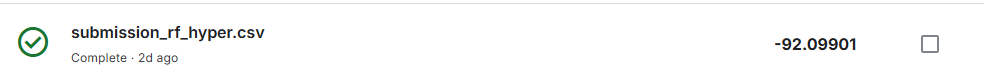

La progression est nette puisque nous étions à 88 précedemment

En effet un des vrais problèmes du german credit est la répartition entre test set (2% risk) et train set (30% de risk).  L'idée suivante va être de rebalancer les classes pour tester si ça permet d'améliorer la submission.

<span style="color:red">Ajout Simon : </span>

En rebalançant, on diminue les poids des Risqués, ainsi on rend moins grave le fait de se tromper sur un crédit qui EST risqué. D'où l'effet négatif sur la performance ? 

## Tentative avec les class weights dans la pipeline

In [25]:
# Calculate class weights based on real vs. training distribution
real_prop = {'Risk': 0.02, 'No Risk': 0.98}
train_prop = {'Risk': 1/3, 'No Risk': 2/3}
class_weights = {
    'Risk': real_prop['Risk'] / train_prop['Risk'],
    'No Risk': real_prop['No Risk'] / train_prop['No Risk']
}

In [ ]:
X_prepared = df_train.drop(columns=['Risk'])
y_prepared = df_train['Risk']

#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    class_weight=class_weights,  # on ajoute les poids ici
    random_state=42
)

# Creer la pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# fit la pipeline et faire les prédictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = np.mean(y_test == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Prepare data for custom loss calculation
y_test_df = pd.DataFrame(y_test, columns=['Risk'])
y_pred_df = pd.DataFrame(y_pred, columns=['Risk'])
y_test_df.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Ajout du loanamount
y_test_df['LoanAmount'] = X_test['LoanAmount']

# Calcul de la loss faite maison
loss = score(y_test_df, y_pred_df, 'LoanAmount')
print(f'Loss: {loss:.2f}')

Accuracy: 72.25%
Loss: -78.81


Moins bonne accuracy et loss sur le test mais ça correspond mieux aux classes finales donc à voir en submission, je la tente. C'était moins bon comme résultat.


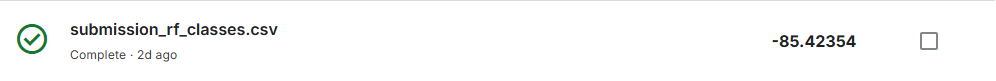

In [61]:
# Je tente des class weights plus agressifs
class_weights = {
    'Risk': (real_prop['Risk'] / train_prop['Risk']) * 5,  # Multiply by 5 to increase penalty
    'No Risk': real_prop['No Risk'] / train_prop['No Risk']
}

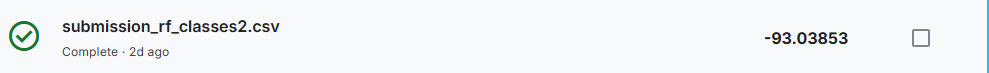

Ce petit changement permet d'encore baisser le score final, on tentera d'augmenter encore la penalité pour voire si il y a un bénéfice à associer des pénalités encore plus élevés à classifier en risque.

Simon 🔴

Pour bien comprendre, ici Alex multiplie par 5 le poids des actifs risqués qui passe donc de 0.06 à 0.30 (4% vs 17%) là où les non risqué stagnent à 1.46 (96% vs 83%).

En soit, ne devrions nous pas simplement testé (finetuné) les poids à savoir trouver ceux qui ressemble le plus à une optimisation de la fonction loss (avec ses particularités ??)

In [ ]:
# Je tente des class weights plus agressifs
class_weights = {
    'Risk': (real_prop['Risk'] / train_prop['Risk']) * 5,  # Multiply by 5 to increase penalty
    'No Risk': real_prop['No Risk'] / train_prop['No Risk']
}

Esssai Simon avec les weights au dessus

In [ ]:
X_prepared = df_train.drop(columns=['Risk'])
y_prepared = df_train['Risk']

#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    class_weight=class_weights,  # on ajoute les poids ici
    random_state=42
)

# Creer la pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# fit la pipeline et faire les prédictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = np.mean(y_test == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Prepare data for custom loss calculation
y_test_df = pd.DataFrame(y_test, columns=['Risk'])
y_pred_df = pd.DataFrame(y_pred, columns=['Risk'])
y_test_df.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Ajout du loanamount
y_test_df['LoanAmount'] = X_test['LoanAmount']

# Calcul de la loss faite maison
loss = score(y_test_df, y_pred_df, 'LoanAmount')
print(f'Loss: {loss:.2f}')

Accuracy: 74.88%
Loss: -81.90


In [ ]:
# Code de simon, nouvelle tentative de submission avec les weights équilibrées 
# et un multiplier de 5 pour les risqués.

y_pred = pipeline.predict(df_test)

# Conversion des prédictions en DataFrame
y_pred = pd.DataFrame(y_pred, columns=['Risk'])
y_pred['Id'] = df_test['Id']

# Réorganiser les colonnes 
submission = y_pred[['Id', 'Risk']]

# Enregistrer au format CSV
submission.to_csv('../03. Submissions/s_submission_rf_hyper.csv', index=False)

### Test de plusieurs weight multipliers

Multiplier: 1.00, Loss: -78.81
Multiplier: 1.80, Loss: -81.01
Multiplier: 2.59, Loss: -82.71
Multiplier: 3.39, Loss: -81.84
Multiplier: 4.18, Loss: -81.61
Multiplier: 4.98, Loss: -82.92
Multiplier: 5.78, Loss: -82.91
Multiplier: 6.57, Loss: -83.06
Multiplier: 7.37, Loss: -84.75
Multiplier: 8.16, Loss: -85.94
Multiplier: 8.96, Loss: -86.23
Multiplier: 9.76, Loss: -85.78
Multiplier: 10.55, Loss: -86.41
Multiplier: 11.35, Loss: -85.96
Multiplier: 12.14, Loss: -86.45
Multiplier: 12.94, Loss: -87.40
Multiplier: 13.73, Loss: -85.47
Multiplier: 14.53, Loss: -84.62
Multiplier: 15.33, Loss: -86.83
Multiplier: 16.12, Loss: -87.20
Multiplier: 16.92, Loss: -86.95
Multiplier: 17.71, Loss: -87.90
Multiplier: 18.51, Loss: -88.89
Multiplier: 19.31, Loss: -87.62
Multiplier: 20.10, Loss: -86.82
Multiplier: 20.90, Loss: -86.21
Multiplier: 21.69, Loss: -83.67
Multiplier: 22.49, Loss: -86.06
Multiplier: 23.29, Loss: -84.72
Multiplier: 24.08, Loss: -84.79
Multiplier: 24.88, Loss: -84.69
Multiplier: 25.67, L

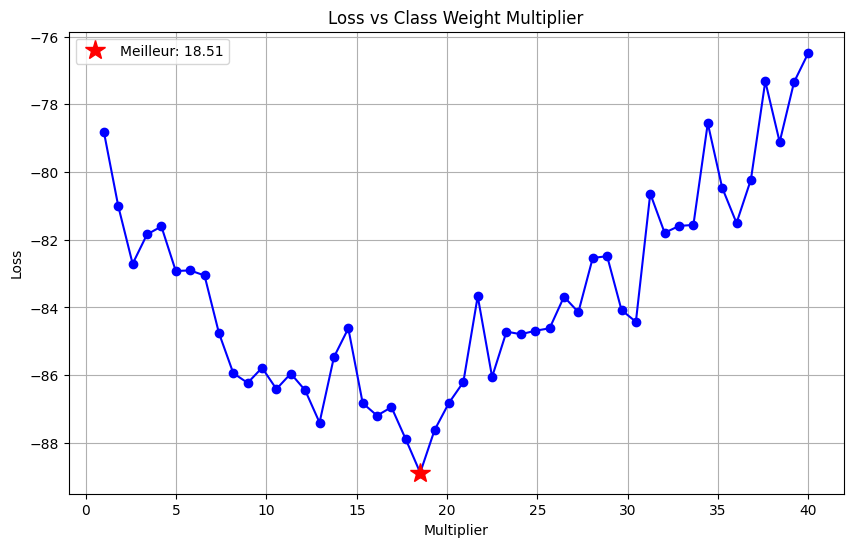

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les multiplicateurs à tester
multipliers = np.linspace(1, 40, 50)  # 20 valeurs entre 1 et 10
losses = []

# Pour chaque multiplicateur
for m in multipliers:
    # Calculer les poids des classes
    class_weights = {
        'Risk': (real_prop['Risk'] / train_prop['Risk']) * m,
        'No Risk': real_prop['No Risk'] / train_prop['No Risk']
    }
    
    # Créer et entraîner le modèle
    rf_classifier = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        class_weight=class_weights,
        random_state=42
    )
    
    # Créer la pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])
    
    # Fit la pipeline et faire les prédictions
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Préparer les données pour le calcul de la loss
    y_test_df = pd.DataFrame(y_test, columns=['Risk'])
    y_pred_df = pd.DataFrame(y_pred, columns=['Risk'])
    y_test_df.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test_df['LoanAmount'] = X_test['LoanAmount']
    
    # Calculer la loss
    loss = score(y_test_df, y_pred_df, 'LoanAmount')
    losses.append(loss)
    
    print(f'Multiplier: {m:.2f}, Loss: {loss:.2f}')

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(multipliers, losses, 'b-', marker='o')
plt.xlabel('Multiplier')
plt.ylabel('Loss')
plt.title('Loss vs Class Weight Multiplier')
plt.grid(True)

# Trouver le meilleur multiplicateur
best_multiplier = multipliers[np.argmin(losses)]
best_loss = min(losses)
print(f'\nMeilleur multiplicateur: {best_multiplier:.2f}')
print(f'Meilleure loss: {best_loss:.2f}')

# Ajouter un point pour le meilleur multiplicateur
plt.plot(best_multiplier, best_loss, 'r*', markersize=15, label=f'Meilleur: {best_multiplier:.2f}')
plt.legend()

plt.show()

## Création d'un seuil personnalisé pour la prédiction

L'idée de cette partie est de travailler sur le seuil de classification de notre classifier pour minimiser notre loss personnalisée.

RF donne des probabilités pour chaque classe
Test de 50 seuils (0.1-0.9) au lieu du défaut 0.5
Pour chaque seuil: probabilités → prédictions → calcul loss
Sélection du seuil minimisant la loss

Validation
Optimisation sur ensemble de validation (20% train)
Évite overfitting sur test
Visualisation loss vs seuil pour stabilité

In [28]:
# Même code que la section d'avant (aggressive weights et pipeline), pas forcément utile de l'avoir en double
#  First, create the main pipeline with aggressive class weights
real_prop = {'Risk': 0.02, 'No Risk': 0.98}
train_prop = {'Risk': 1/3, 'No Risk': 2/3}
class_weights = {
    'Risk': (real_prop['Risk'] / train_prop['Risk']) * 7,
    'No Risk': real_prop['No Risk'] / train_prop['No Risk']
}

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    class_weight=class_weights,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['LoanDuration', 'LoanAmount', 'InstallmentPercent',
       'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount',
       'Dependents'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings',
       'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty',
       'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight={'No Risk': 1.47,
                                                      'Risk': 0.42000000000000004},
                                        max_depth=10, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

Best threshold: 0.443
Best validation loss: -100.306


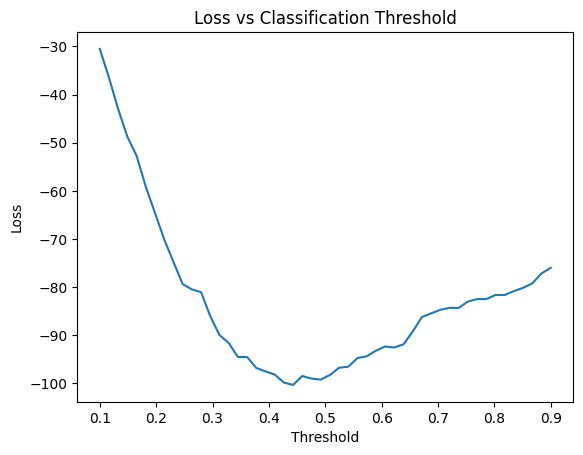

In [29]:

def find_optimal_threshold(pipeline, X, y_true, thresholds=np.linspace(0.1, 0.9, 50)):
    """
    Find the optimal threshold for classification based on custom loss function
    """
    # Get probabilities
    y_proba = pipeline.predict_proba(X)[:, 1]  # Probability of "Risk"

    # Prepare true values DataFrame
    y_true_df = pd.DataFrame(y_true, columns=['Risk'])
    y_true_df['LoanAmount'] = X['LoanAmount']
    y_true_df.reset_index(drop=True, inplace=True)

    # Test different thresholds
    losses = []
    for thresh in thresholds:
        # Convert probabilities to predictions using threshold
        y_pred = (y_proba > thresh).astype(int)
        y_pred = pd.DataFrame({'Risk': np.where(y_pred == 1, 'Risk', 'No Risk')})

        # Calculate loss for this threshold
        current_loss = score(y_true_df, y_pred, 'LoanAmount')
        losses.append(current_loss)

    # Find best threshold
    best_threshold = thresholds[np.argmin(losses)]
    best_loss = min(losses)

    return best_threshold, best_loss, losses

# Find optimal threshold on validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Retrain on training validation set
pipeline.fit(X_train_val, y_train_val)

# Find optimal threshold
best_threshold, best_val_loss, losses = find_optimal_threshold(
    pipeline, X_val, y_val
)

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")

# Plot losses vs thresholds if you want to visualize
import matplotlib.pyplot as plt
plt.plot(np.linspace(0.1, 0.9, 50), losses)
plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.title('Loss vs Classification Threshold')
plt.show()

On voit qu'on obtient un threshold autour de 0.443 ce qui est en dessous du 0,5 théorique, ce qui est intéressant pour nous.

In [30]:
# Final prediction function using optimal threshold
def predict_with_threshold(pipeline, X, threshold):
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba > threshold).astype(int)
    return pd.DataFrame({'Risk': np.where(y_pred == 1, 'Risk', 'No Risk')})

# Retrain on full training set and make final predictions
pipeline.fit(X_train, y_train)
y_pred_final = predict_with_threshold(pipeline, X_test, best_threshold)

# Calculate final loss
y_test_df = pd.DataFrame(y_test, columns=['Risk'])
y_test_df['LoanAmount'] = X_test['LoanAmount']
y_test_df.reset_index(drop=True, inplace=True)

final_loss = score(y_test_df, y_pred_final, 'LoanAmount')
print(f"Final test loss with optimal threshold: {final_loss:.3f}")

Final test loss with optimal threshold: -126.657


In [33]:
# Load full test set (assuming it's named X_test_full)
X_prepared = df_train.drop(columns=['Risk'])
y_prepared = df_train['Risk']

def prepare_submission(pipeline, X_test, best_threshold):
    """
    Make predictions on full test set and format for submission
    """
    # Make predictions using optimal threshold
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > best_threshold).astype(int)

    # Convert to submission format
    submission = pd.DataFrame({
        'Risk': np.where(y_pred == 1, 'Risk', 'No Risk')
    })

    return submission

# Generate submission
submission = prepare_submission(pipeline, df_test, best_threshold)

# Save submission
submission.to_csv('../03. Submissions/test_submission_best_threshold.csv')

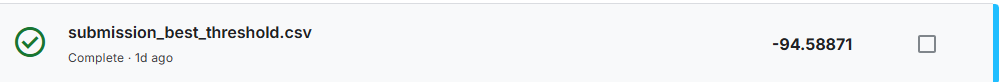

Cette méthode nous permet d'obtenir notre meilleur score jusqu'à maintenant.

## Feature Engineering 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os

# Import utility functions
from utils import score, compute_costs, calculate_custom_loss
from enhanced_feature import engineer_features

# Ensure directories exist
os.makedirs('../03. Submissions', exist_ok=True)

# Function to find optimal threshold
def find_optimal_threshold(model, X, y_true, thresholds=np.linspace(0.1, 0.9, 50)):
    """
    Find the optimal threshold for classification based on custom loss function
    """
    # Get probabilities
    y_proba = model.predict_proba(X)[:, 1]  # Probability of "Risk"

    # Prepare true values DataFrame
    y_true_df = pd.DataFrame(y_true, columns=['Risk'])
    y_true_df['LoanAmount'] = X['LoanAmount']
    y_true_df.reset_index(drop=True, inplace=True)

    # Test different thresholds
    losses = []
    for thresh in thresholds:
        # Convert probabilities to predictions using threshold
        y_pred = (y_proba > thresh).astype(int)
        y_pred = pd.DataFrame({'Risk': np.where(y_pred == 1, 'Risk', 'No Risk')})

        # Calculate loss for this threshold using your utility function
        current_loss = score(y_true_df, y_pred, 'LoanAmount')
        losses.append(current_loss)

    # Find best threshold
    best_threshold = thresholds[np.argmin(losses)]
    best_loss = min(losses)

    return best_threshold, best_loss, losses


def run_optimized_rf(df_train, df_test, multiplier=7, test_multiple_multipliers=False):
    """
    Run Random Forest solution with optimized weights and threshold

    Parameters:
    -----------
    df_train: DataFrame
        Training data
    df_test: DataFrame
        Test data for predictions
    multiplier: int
        Multiplier for 'Risk' class weight
    test_multiple_multipliers: bool
        Whether to test multiple multipliers
    """
    # Engineer features using your function
    X_train_eng = engineer_features(df_train)
    X_test_eng = engineer_features(df_test)

    X = X_train_eng.drop(columns=['Risk'])
    y = X_train_eng['Risk']

    # Define numerical and categorical features
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=[object]).columns.tolist()

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Test multiple multipliers if requested
    if test_multiple_multipliers:
        multipliers = [1, 3, 5, 7, 9, 11, 13, 15]
        results = []

        for mult in multipliers:
            print(f"Testing multiplier: {mult}")

            # Define class weights
            real_prop = {'Risk': .02, 'No Risk': .98}
            train_prop = {'Risk': 1/3, 'No Risk': 2/3}

            class_weights = {
                'Risk': (real_prop['Risk'] / train_prop['Risk']) * mult,
                'No Risk': real_prop['No Risk'] / train_prop['No Risk']
            }

            # Create Random Forest classifier
            rf_classifier = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_leaf=1,
                min_samples_split=5,
                class_weight=class_weights,
                random_state=42
            )

            # Create and fit pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', rf_classifier)
            ])

            pipeline.fit(X_train, y_train)

            # Find optimal threshold
            best_threshold, val_loss, _ = find_optimal_threshold(pipeline, X_val, y_val)

            # Store results
            results.append({
                'multiplier': mult,
                'threshold': best_threshold,
                'validation_loss': val_loss
            })

            print(f"  Threshold: {best_threshold:.3f}, Loss: {val_loss:.3f}")

        # Find best multiplier
        best_result = min(results, key=lambda x: x['validation_loss'])
        multiplier = best_result['multiplier']

        print(f"\nBest multiplier: {multiplier}")
        print(f"Best threshold: {best_result['threshold']:.3f}")
        print(f"Best validation loss: {best_result['validation_loss']:.3f}")

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot([r['multiplier'] for r in results], [r['validation_loss'] for r in results], marker='o')
        plt.xlabel('Risk Weight Multiplier')
        plt.ylabel('Validation Loss')
        plt.title('Validation Loss vs Risk Weight Multiplier')
        plt.grid(True)

    # Create final model with best multiplier
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}

    class_weights = {
        'Risk': (real_prop['Risk'] / train_prop['Risk']) * multiplier,
        'No Risk': real_prop['No Risk'] / train_prop['No Risk']
    }

    # Create Random Forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        class_weight=class_weights,
        random_state=42
    )

    # Create and fit pipeline for validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    pipeline.fit(X_train, y_train)

    # Find optimal threshold
    best_threshold, val_loss, _ = find_optimal_threshold(pipeline, X_val, y_val)
    print(f"\nFinal model - Multiplier: {multiplier}")
    print(f"Threshold: {best_threshold:.3f}, Validation loss: {val_loss:.3f}")

    # Train final model on all data
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    final_pipeline.fit(X, y)

    # Make predictions with optimal threshold
    test_proba = final_pipeline.predict_proba(X_test_eng)[:, 1]
    test_preds = (test_proba > best_threshold).astype(int)

    # Create submission
    submission = pd.DataFrame({
        'Risk': np.where(test_preds == 1, 'Risk', 'No Risk'),
        'Id': df_test['Id'] if 'Id' in df_test.columns else range(len(test_preds))
    })

    if 'Id' in df_test.columns:
        submission = submission[['Id', 'Risk']]

    # Save submission
    submission_path = f'../03. Submissions/rf_submission_m{multiplier}_t{best_threshold:.3f}.csv'

    submission.to_csv(submission_path, index=False)

    print(f"\nSubmission saved to: {submission_path}")
    # Calculate feature importances
    if hasattr(final_pipeline.named_steps['classifier'], 'feature_importances_'):
        # Get feature names after one-hot encoding
        categorical_encoder = final_pipeline.named_steps['preprocessor'].transformers_[1][1]
        cat_feature_names = categorical_encoder.get_feature_names_out(categorical_features)

        # Combine numeric and categorical feature names
        feature_names = numeric_features + list(cat_feature_names)

        # Get feature importances from the model
        importances = final_pipeline.named_steps['classifier'].feature_importances_

        # Create a DataFrame for visualization
        if len(feature_names) == len(importances):
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })
            feature_imp = feature_imp.sort_values('Importance', ascending=False)

            # Plot top 20 features
            plt.figure(figsize=(12, 8))
            plt.barh(feature_imp.head(20)['Feature'], feature_imp.head(20)['Importance'])
            plt.xlabel('Importance')
            plt.title('Top 20 Feature Importances')
            plt.gca().invert_yaxis()  # Display the highest importance at the top
            plt.tight_layout()

    return {
        'model': final_pipeline,
        'best_threshold': best_threshold,
        'multiplier': multiplier,
        'validation_loss': val_loss,
        'submission': submission,
        'submission_path': submission_path
    }


# Example usage
if __name__ == "__main__":
    print("Loading data...")
    df_train = pd.read_csv("../01.Data/german_credit_train.csv")
    df_test = pd.read_csv("../01.Data/german_credit_test.csv")

    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

    # Run with default multiplier = 7
    results = run_optimized_rf(df_train, df_test, multiplier=7)

    # Uncomment to test multiple multipliers
    results = run_optimized_rf(df_train, df_test, test_multiple_multipliers=True)

Loading data...
Train shape: (3999, 21), Test shape: (1001, 21)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Après ces tentatives plutôt fructueuses même si elles ne se traduisent pas vraiment en une meilleure submission je les ai placé dans une fonction enhanced feature pour ne pas réinvter la roue.

## Tentative avec Gradient Boosting (LightGBM)

In [2]:
# Import the module
from xgboost_simple import run_xgboost
import pandas as pd

# Load data
df_train = pd.read_csv("../01.Data/german_credit_train.csv")
df_test = pd.read_csv("../01.Data/german_credit_test.csv")

# Run XGBoost with multiplier=5
results = run_xgboost(df_train, df_test, scale_pos_weight_multiplier=5)

# Access results
print(f"Validation loss: {results['validation_loss']:.3f}")
print(f"Best threshold: {results['best_threshold']:.3f}")
print(f"Submission file: {results['submission_path']}")

Running XGBoost model...
Using enhanced features from engineer_features()
Using scale_pos_weight: 122.5000
Training XGBoost with 200 trees...
Best threshold: 0.900, Validation loss: -51.431
Submission saved to: ../03. Submissions/xgb_simple_spw5_t0.900.csv
Validation loss: -51.431
Best threshold: 0.900
Submission file: ../03. Submissions/xgb_simple_spw5_t0.900.csv


In [3]:
from xgboost_class_weight import run_xgboost_class_weight

# Load data
df_train = pd.read_csv("../01.Data/german_credit_train.csv")
df_test = pd.read_csv("../01.Data/german_credit_test.csv")

# Run with automatic tuning (tests many class weight configurations)
results = run_xgboost_class_weight(df_train, df_test, tuning=True)

# Access detailed results
results_df = results['results_df']
print(results_df.sort_values('loss').head(10))  # View top 10 configurations

Running XGBoost with enhanced class weight handling...
Using enhanced features from engineer_features()
Tuning XGBoost with focus on class weights...

Testing configuration 1/14:
  scale_pos_weight: 1
  max_depth: 4
  learning_rate: 0.05
  Loss: -92.484, Threshold: 0.650, Accuracy: 0.787
  Risk predictions at t=0.5: 177/800 (22.12%)
  Risk predictions at t=0.2: 438/800 (54.75%)
  Risk predictions at t=0.8: 62/800 (7.75%)
  New best configuration!

Testing configuration 2/14:
  scale_pos_weight: 2
  max_depth: 4
  learning_rate: 0.05
  Loss: -92.811, Threshold: 0.790, Accuracy: 0.782
  Risk predictions at t=0.5: 281/800 (35.12%)
  Risk predictions at t=0.2: 530/800 (66.25%)
  Risk predictions at t=0.8: 111/800 (13.88%)
  New best configuration!

Testing configuration 3/14:
  scale_pos_weight: 3
  max_depth: 4
  learning_rate: 0.05
  Loss: -94.134, Threshold: 0.830, Accuracy: 0.789
  Risk predictions at t=0.5: 371/800 (46.38%)
  Risk predictions at t=0.2: 574/800 (71.75%)
  Risk predicti

Beaucoup de tentative pour peu de résultats concluants...

Tout a été supprimé (fonctions models) pour garder le code le plus clean possible, pas de départ dans la mauvaise direction.

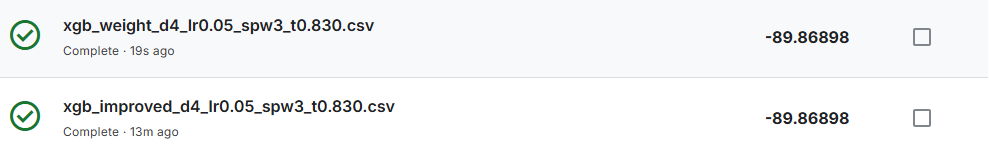

## On repart sur du Random Forest pour vérifier si le feature engineering est utile

In [ ]:
from rf_minimal import test_multiple_multipliers
import pandas as pd

# Load data
df_train = pd.read_csv("../01.Data/german_credit_train.csv")
df_test = pd.read_csv("../01.Data/german_credit_test.csv")

# Optionally test multiple multipliers
results = test_multiple_multipliers(df_train, df_test,
                                   multipliers=[5, 6, 7, 8, 9])


=== Testing multiplier = 5 ===
Running optimized Random Forest (multiplier=5)
Using original features only
Class weights: {'Risk': 0.30000000000000004, 'No Risk': 1.47}
Best threshold: 0.440, Validation loss: -94.270
Submission saved to: ../03. Submissions/rf_submission_m5_t0.440.csv

=== Testing multiplier = 6 ===
Running optimized Random Forest (multiplier=6)
Using original features only
Class weights: {'Risk': 0.36000000000000004, 'No Risk': 1.47}
Best threshold: 0.450, Validation loss: -94.424
Submission saved to: ../03. Submissions/rf_submission_m6_t0.450.csv

=== Testing multiplier = 7 ===
Running optimized Random Forest (multiplier=7)
Using original features only
Class weights: {'Risk': 0.42000000000000004, 'No Risk': 1.47}
Best threshold: 0.460, Validation loss: -95.757
Submission saved to: ../03. Submissions/rf_submission_m7_t0.460.csv

=== Testing multiplier = 8 ===
Running optimized Random Forest (multiplier=8)
Using original features only
Class weights: {'Risk': 0.48000000

In [3]:
from rf_minimal import run_optimized_rf

# Or run a series of tests to compare both approaches
results1 = run_optimized_rf(df_train, df_test, multiplier=7, use_feature_engineering=False)
results2 = run_optimized_rf(df_train, df_test, multiplier=7, use_feature_engineering=True)

print(f"Original features loss: {results1['validation_loss']:.3f}")
print(f"Enhanced features loss: {results2['validation_loss']:.3f}")

Running optimized Random Forest (multiplier=7)
Using original features only
Class weights: {'Risk': 0.42000000000000004, 'No Risk': 1.47}
Best threshold: 0.460, Validation loss: -95.757
Submission saved to: ../03. Submissions/rf_submission_m7_t0.460.csv
Running optimized Random Forest (multiplier=7)
Using enhanced features
Class weights: {'Risk': 0.42000000000000004, 'No Risk': 1.47}
Best threshold: 0.500, Validation loss: -94.293
Submission saved to: ../03. Submissions/rf_submission_m7_t0.500_fe.csv
Original features loss: -95.757
Enhanced features loss: -94.293


## Ensemble method starting from Random Forest (averaging results)

In [78]:
# Load the script
from rf_ensemble import create_rf_ensemble # Import the function from a python file
import pandas as pd

# Load data
df_train = pd.read_csv("../01.Data/german_credit_train.csv")
df_test = pd.read_csv("../01.Data/german_credit_test.csv")

In [79]:
# Create ensemble with 10 models and multiplier=7
results = create_rf_ensemble(
    df_train, df_test,
    n_models=10,  # Number of models in the ensemble
    multiplier=7,  # best multiplier so far
)


Creating RF ensemble with 10 models (multiplier=7)
Class weights: {'Risk': 0.42000000000000004, 'No Risk': 1.47}
Training model 1/10...
Training model 2/10...
Training model 3/10...
Training model 4/10...
Training model 5/10...
Training model 6/10...
Training model 7/10...
Training model 8/10...
Training model 9/10...
Training model 10/10...
Best threshold: 0.460, Validation loss: -94.074
Ensemble training completed in 4.3 seconds
Submission saved to: ../03. Submissions/rf_ensemble_n10_m7_t0.460.csv


Creating RF ensemble with 10 models (multiplier=18.5)
Class weights: {'Risk': 1.11, 'No Risk': 1.47}
Training model 1/10...
Training model 2/10...
Training model 3/10...
Training model 4/10...
Training model 5/10...
Training model 6/10...
Training model 7/10...
Training model 8/10...
Training model 9/10...
Training model 10/10...
Best threshold: 0.550, Validation loss: -94.126
Ensemble training completed in 3.9 seconds
Submission saved to: ../03. Submissions/rf_ensemble_n10_m18.5_t0.550.csv
Creating RF ensemble with 10 models (multiplier=1.0)
Class weights: {'Risk': 0.060000000000000005, 'No Risk': 1.47}
Training model 1/10...
Training model 2/10...
Training model 3/10...
Training model 4/10...
Training model 5/10...
Training model 6/10...
Training model 7/10...
Training model 8/10...
Training model 9/10...
Training model 10/10...
Best threshold: 0.290, Validation loss: -93.100
Ensemble training completed in 3.9 seconds
Submission saved to: ../03. Submissions/rf_ensemble_n10_m1.0_t0.29

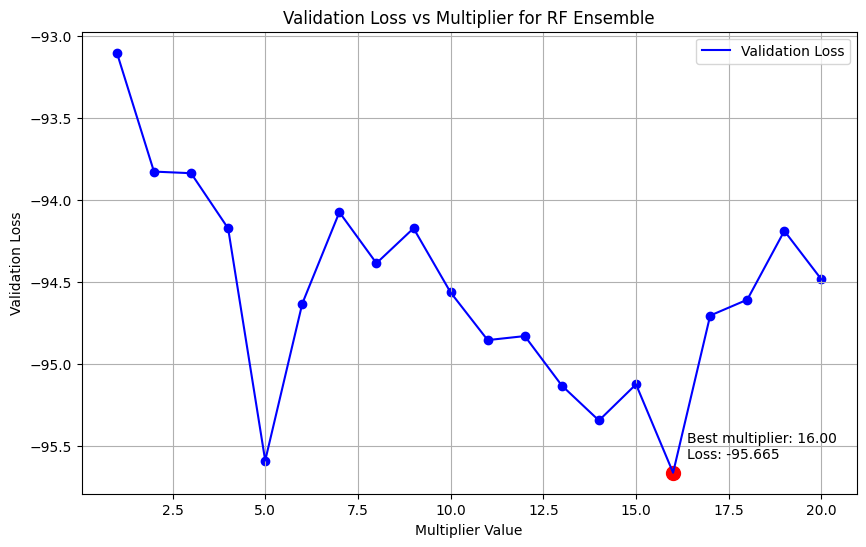

Best multiplier: 16.00
Best validation loss: -95.665


In [71]:
# Test Simon avec un multiplier différent 
# Create ensemble with 10 models and multiplier=7
results = create_rf_ensemble(
    df_train, df_test,
    n_models=10,  # Number of models in the ensemble
    multiplier=18.5,  # best multiplier so far
)

# Test different multipliers and plot results
import numpy as np
import matplotlib.pyplot as plt

# Define range of multipliers to test
multipliers = np.linspace(1, 20, 20)
losses = []

# Calculate loss for each multiplier
for mult in multipliers:
    results = create_rf_ensemble(
        df_train, df_test,
        n_models=10,
        multiplier=mult
    )
    losses.append(results['validation_loss'])

# Plot results
plt.figure(figsize=(10,6))
plt.plot(multipliers, losses, 'b-', label='Validation Loss')
plt.scatter(multipliers, losses, c='b')
plt.xlabel('Multiplier Value')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Multiplier for RF Ensemble')
plt.grid(True)
plt.legend()

# Find and mark best multiplier
best_mult = multipliers[np.argmin(losses)]
min_loss = min(losses)
plt.scatter(best_mult, min_loss, c='r', s=100, label=f'Best: {best_mult:.2f}')
plt.annotate(f'Best multiplier: {best_mult:.2f}\nLoss: {min_loss:.3f}', 
            xy=(best_mult, min_loss), xytext=(10, 10),
            textcoords='offset points')

plt.show()

print(f"Best multiplier: {best_mult:.2f}")
print(f"Best validation loss: {min_loss:.3f}")


## Génération d'une submission avec le dernier pipeline utilisé

In [ ]:
# Entrainement du modèle sur toutes les données à disposition
pipeline.fit(X_prepared, y_prepared)

# Prédictions sur les données de test
y_pred = pipeline.predict(df_test)

# Conversion des prédictions en DataFrame
y_pred = pd.DataFrame(y_pred, columns=['Risk'])
y_pred['Id'] = df_test['Id']

# Réorganiser les colonnes
submission = y_pred[['Id', 'Risk']]

# Enregistrer au format CSV
submission.to_csv('../03. Submissions/submission_rf_threshold2.csv', index=False)

## Creation of a second algorithm using a Neural Network with Keras

Préparons les données (les mettre sous formes numériques) pour appliquer le NN

In [ ]:
# Préparation des données
X = df_train.drop(columns=['Risk'])
y = df_train['Risk']

# Conversion des étiquettes en valeurs numériques
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création des transformateurs pour les colonnes catégorielles et numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Transformation des données
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

<span style="color:red;">Dans le modèle ci-dessous, l'entraiment du reseau de neurone est fait de manière à minimiser la loss, mais est-ce que cette dernière peut être minimiser sur des valeurs négatives?? </span>

In [ ]:
def compute_costs(LoanAmount):
    return {'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
            'Risk_Risk': 1.0, 'No Risk_Risk': 1.0}

def custom_loss(y_true, y_pred):
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}
    custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}

    # Supposons que LoanAmount soit une colonne de X_train_transformed
    LoanAmount = X_train_transformed[:, X_train.columns.get_loc('LoanAmount')]
    costs = compute_costs(LoanAmount)

    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    loss = (y_true * custom_weight['Risk'] *
            (y_pred * costs['Risk_Risk'] + (1 - y_pred) * costs['Risk_No Risk']) +
            (1 - y_true) * custom_weight['No Risk'] *
            (y_pred * costs['No Risk_Risk'] + (1 - y_pred) * costs['No Risk_No Risk']))

    return K.mean(loss)

# Définition du modèle
model = Sequential([
    Input(shape=(X_train_transformed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle avec la fonction de perte personnalisée
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss, metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train_transformed, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3594 - loss: 1.0188 - val_accuracy: 0.3172 - val_loss: 1.0231
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3316 - loss: 1.0026 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3331 - loss: 1.0004 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3300 - loss: 1.0047 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3226 - loss: 1.0151 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3400 - loss: 0.9906 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3286 - loss: 1.0066 - val_accuracy: 0.3172 - val_loss: 1.0228
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3162 - loss: 1.0242 - val_accuracy: 0.3172 - val_loss: